(pbt-guide-ref)=

# A Guide to Population Based Training

Tune includes a distributed implementation of [Population Based Training (PBT)](https://www.deepmind.com/blog/population-based-training-of-neural-networks) as
a [scheduler](tune-scheduler-pbt).

![Paper figure](/images/tune_advanced_paper1.png)


PBT starts by training many neural networks in parallel with random hyperparameters, using information from the rest of the population to refine these
hyperparameters and allocate resources to promising models. Let's walk through how to use this algorithm.

```{contents}
    :local:
    :backlinks: none
```

## Function API with Population Based Training

PBT takes its inspiration from genetic algorithms where poor performing members of the population
can exploit information from the top performers the population. In our case, the *population*
is the set of Tune trials running in parallel, where trial performance is determined by a user-specified
metric such as `mean_accuracy`.

PBT has two main steps: **exploitation** and **exploration**.
One example of exploitation is a trial copying the model parameters from a better performing trial.
One example of exploration is generating a new hyperparameter configuration by perturbing the current values randomly.

As the training of the population of neural networks progresses, this process of exploiting and exploring
is performed periodically, ensuring that all the workers in the population have a good base level of performance
and also consistently exploring new hyperparameters configurations.
This means that PBT can quickly exploit good hyperparameters, dedicate more training time to
promising models and, crucially, mutate the hyperparameter values throughout training,
leading to learning the best *adaptive* hyperparameter schedules.

Here, we will walk through how to use PBT using a MNIST ConvNet training example. First, we define a training function that trains a ConvNet model using SGD.

In [ ]:
!pip install "ray[tune]"

In [ ]:
import torch
import torch.optim as optim

import ray
from ray import tune, air
from ray.air import session, Checkpoint
from ray.tune.examples.mnist_pytorch import ConvNet, get_data_loaders, train, test
from ray.tune.schedulers import PopulationBasedTraining


def train_convnet(config):
    # Create our data loaders, model, and optmizer.
    step = 1
    train_loader, test_loader = get_data_loaders()
    model = ConvNet()
    optimizer = optim.SGD(
        model.parameters(),
        lr=config.get("lr", 0.01),
        momentum=config.get("momentum", 0.9),
    )

    # If `session.get_checkpoint()` is not None, then we are resuming from a checkpoint.
    # Load model state and iteration step from checkpoint.
    if session.get_checkpoint():
        checkpoint_dict = session.get_checkpoint().to_dict()
        model.load_state_dict(checkpoint_dict["model_state_dict"])
        # Note: Make sure to increment the checkpointed step by 1 to get the current step.
        last_step = checkpoint_dict["step"]
        step = last_step + 1

    while True:
        train(model, optimizer, train_loader)
        acc = test(model, test_loader)
        checkpoint = None
        if step % config["checkpoint_interval"] == 0:
            # Every 5 steps, checkpoint our current state.
            checkpoint = Checkpoint.from_dict({
                "step": step,
                "model_state_dict": model.state_dict(),
            })

        session.report({"mean_accuracy": acc, "lr": config["lr"]}, checkpoint=checkpoint)
        step += 1

The example reuses some of the functions in `ray/tune/examples/mnist_pytorch.py`, and is also a good
demo for how to decouple the tuning logic and original training code.

**Checkpointing saving and loading is required for PBT**, so we have to both load in the checkpoint if one is provided via `session.get_checkpoint()`, and periodically save our
model state in a checkpoint via `session.report(...)` - in this case every 5 iterations. With SGD, there's no need to checkpoint the optimizer
since it does not depend on previous states, but this is necessary with other optimizers like Adam (the next example on GAN training gives an example on loading optimizer states).

Then, we define a PBT scheduler:

In [2]:
perturbation_interval = 5
scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    perturbation_interval=perturbation_interval,
    metric="mean_accuracy",
    mode="max",
    hyperparam_mutations={
        # distribution for resampling
        "lr": tune.uniform(0.0001, 1),
        # allow perturbations within this set of categorical values
        "momentum": [0.8, 0.9, 0.99],
    },
)

Some of the most important parameters are:

- ``hyperparam_mutations`` and ``custom_explore_fn`` are used to mutate the hyperparameters.
  ``hyperparam_mutations`` is a dictionary where each key/value pair specifies the candidates
  or function for a hyperparameter. custom_explore_fn is applied after built-in perturbations
  from hyperparam_mutations are applied, and should return config updated as needed.

- ``resample_probability``: The probability of resampling from the original distribution
  when applying hyperparam_mutations. If not resampled, the value will be perturbed by a
  factor of 1.2 or 0.8 if continuous, or changed to an adjacent value if discrete. Note that
  ``resample_probability`` by default is 0.25, thus hyperparameter with a distribution
  may go out of the specific range.

Now we can kick off the tuning process by invoking ``Tuner.fit()``:

In [ ]:
if ray.is_initialized():
    ray.shutdown()
ray.init()

tuner = tune.Tuner(
    train_convnet,
    run_config=air.RunConfig(
        name="pbt_test",
        # Stop when we've reached a threshold accuracy, or a maximum
        # training_iteration, whichever comes first
        stop={"mean_accuracy": 0.96, "training_iteration": 100},
        verbose=1,
        checkpoint_config=air.CheckpointConfig(
            checkpoint_score_attribute="mean_accuracy",
            num_to_keep=4,
        ),
    ),
    tune_config=tune.TuneConfig(
        scheduler=scheduler,
        num_samples=4,
    ),
    param_space={
        "lr": tune.uniform(0.001, 1),
        "momentum": tune.uniform(0.001, 1),
        "checkpoint_interval": perturbation_interval,
    },
)

results_grid = tuner.fit()

```{note}
We recommend matching `checkpoint_interval` with `perturbation_interval` from the PBT config.
This ensures that the PBT algorithm actually exploits the trials in the most recent iteration.

If your `perturbation_interval` is large and want to checkpoint more frequently, set `perturbation_interval` to be a multiple of `checkpoint_interval` (e.g. checkpoint every 2 steps and perturb every 4 steps).
```

In `{LOG_DIR}/{MY_EXPERIMENT_NAME}/`, all mutations are logged in `pbt_global.txt` and individual policy perturbations are recorded in `pbt_policy_{i}.txt`. Tune logs the following information on each perturbation step: target trial tag, clone trial tag, target trial iteration, clone trial iteration, old config, new config.

Checking the accuracy:

Best result logdir: ~/ray_results/pbt_test/train_convnet_4a988_00003_3_lr=0.1602,momentum=0.0277_2022-10-04_11-42-27
Best final iteration hyperparameter config:
 {'lr': 0.16017377280486686, 'momentum': 0.027710090689824624, 'checkpoint_interval': 5}


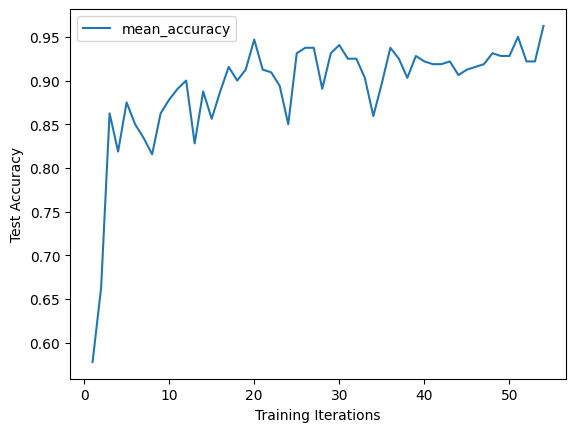

In [5]:
import matplotlib.pyplot as plt
import os

# Get the best trial result
best_result = results_grid.get_best_result(metric="mean_accuracy", mode="max")

# Print `log_dir` where checkpoints are stored
# (Remove user-specific information from path)
relative_log_dir = os.path.relpath(best_result.log_dir, os.path.expanduser("~/ray_results"))
print('Best result logdir:', os.path.join("~/ray_results", relative_log_dir))

# Print the best trial `config` reported at the last iteration
# NOTE: This config is just what the trial ended up with at the last iteration.
# See the next section for replaying the entire history of configs.
print('Best final iteration hyperparameter config:\n', best_result.config)

# Plot the learning curve for the best trial
df = best_result.metrics_dataframe
# Deduplicate, since PBT might introduce duplicate data
df = df.drop_duplicates(subset="training_iteration", keep="last")
df.plot("training_iteration", "mean_accuracy")
plt.xlabel("Training Iterations")
plt.ylabel("Test Accuracy")
plt.show()

(tune-advanced-tutorial-pbt-replay)=

## Replaying a PBT run

A run of Population Based Training ends with fully trained models. However, sometimes
you might like to train the model from scratch, but use the same hyperparameter
schedule as obtained from PBT. Ray Tune offers a replay utility for this.

All you need to do is pass the policy log file for the trial you want to replay.
This is usually stored in the experiment directory, for instance
``~/ray_results/pbt_test/pbt_policy_ba982_00000.txt``.

The replay utility reads the original configuration for the trial and updates it
each time when it was originally perturbed. You can (and should)
thus just use the same ``Trainable`` for the replay run. Note that the end result
will not be exactly the same, since only the hyperparameter config changes are replayed,
not the checkpoint loading from other samples.

In [ ]:
import glob

from ray import tune
from ray.tune.schedulers import PopulationBasedTrainingReplay

# Get a random replay policy from the experiment we just ran
sample_pbt_trial_log = glob.glob(os.path.expanduser("~/ray_results/pbt_test/pbt_policy*.txt"))[0]
replay = PopulationBasedTrainingReplay(sample_pbt_trial_log)

tuner = tune.Tuner(
    train_convnet,
    tune_config=tune.TuneConfig(scheduler=replay),
    run_config=air.RunConfig(stop={"training_iteration": 100}),
)
results_grid = tuner.fit()

## Example: DCGAN with PBT

Let's take a look at a more involved example: training Generative Adversarial Networks (GAN) (Goodfellow et al., 2014).
The GAN framework learns generative
models via a training paradigm consisting of two competing modules – a generator and a
discriminator. **GAN training can be remarkably brittle and unstable in the face of suboptimal
hyperparameter selection** with generators often collapsing to a single mode or diverging entirely.

As presented in [Population Based Training (PBT)](https://www.deepmind.com/blog/population-based-training-of-neural-networks>),
PBT can help with the DCGAN training. We will now walk through how to do this in Tune.
The complete code example is on [Github](https://github.com/ray-project/ray/tree/master/python/ray/tune/examples/pbt_dcgan_mnist).

We define the Generator and Discriminator with standard Pytorch API:

```{literalinclude} /../../python/ray/tune/examples/pbt_dcgan_mnist/common.py
   :language: python
   :start-after: __GANmodel_begin__
   :end-before: __GANmodel_end__
```

To train the model with PBT, we need to define a metric for the scheduler to evaluate
the model candidates. For a GAN network, inception score is arguably the most
commonly used metric. We trained a mnist classification model (LeNet) and use
it to inference the generated images and evaluate the image quality.

```{literalinclude} /../../python/ray/tune/examples/pbt_dcgan_mnist/common.py
   :language: python
   :start-after: __INCEPTION_SCORE_begin__
   :end-before: __INCEPTION_SCORE_end__
```

We define a training function that includes a Generator and a Discriminator,
each with an independent learning rate and optimizer. We make sure to implement checkpointing for our training.
In particular, note that we need to set the optimizer learning rates after loading from a checkpoint, since we want to use the perturbed config passed to us in `config` rather than the exact same config as the trial we are exploiting.

```{literalinclude} /../../python/ray/tune/examples/pbt_dcgan_mnist/pbt_dcgan_mnist_func.py
   :language: python
   :start-after: __Train_begin__
   :end-before: __Train_end__
```

We specify inception score as the metric and start the tuning:

In [ ]:
import torch
import ray
from ray import air, tune
from ray.tune.schedulers import PopulationBasedTraining

from ray.tune.examples.pbt_dcgan_mnist.common import Net
from ray.tune.examples.pbt_dcgan_mnist.pbt_dcgan_mnist_func import (
    dcgan_train, download_mnist_cnn
)

# Load the pretrained mnist classification model for inception_score
mnist_cnn = Net()
model_path = download_mnist_cnn()
mnist_cnn.load_state_dict(torch.load(model_path))
mnist_cnn.eval()
# Put the model in Ray object store.
mnist_model_ref = ray.put(mnist_cnn)

perturbation_interval = 5
scheduler = PopulationBasedTraining(
    perturbation_interval=perturbation_interval,
    hyperparam_mutations={
        # Distribution for resampling
        "netG_lr": tune.uniform(1e-2, 1e-5),
        "netD_lr": tune.uniform(1e-2, 1e-5),
    },
)

smoke_test = False
tune_iter = 5 if smoke_test else 200
tuner = tune.Tuner(
    dcgan_train,
    run_config=air.RunConfig(
        name="pbt_dcgan_mnist_tutorial",
        stop={"training_iteration": tune_iter},
        verbose=1,
    ),
    tune_config=tune.TuneConfig(
        metric="is_score",
        mode="max",
        num_samples=8,
        scheduler=scheduler,
    ),
    param_space={
        # Define how initial values of the learning rates should be chosen.
        "netG_lr": tune.choice([0.0001, 0.0002, 0.0005]),
        "netD_lr": tune.choice([0.0001, 0.0002, 0.0005]),
        "mnist_model_ref": mnist_model_ref,
        "checkpoint_interval": perturbation_interval,
    },
)
results_grid = tuner.fit()

The trained Generator models can be loaded from checkpoints in the log directory and generate images
from noise signals.

## Visualization

Below, we visualize the increasing inception score from the training logs.

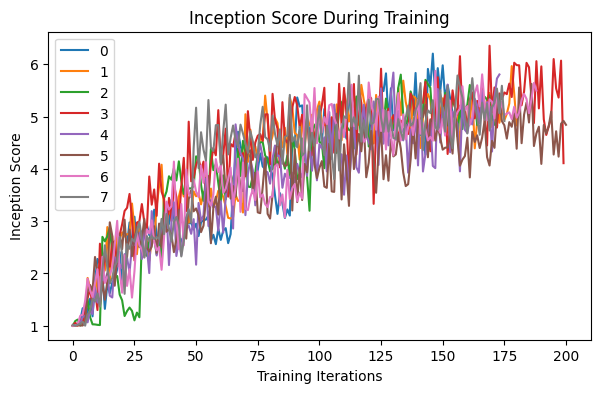

In [17]:
import matplotlib.pyplot as plt

result_dfs = [result.metrics_dataframe for result in results_grid]
best_result = results_grid.get_best_result(metric="is_score", mode="max")

plt.figure(figsize=(7, 4))
for i, df in enumerate(result_dfs):
    plt.plot(df["is_score"], label=i)
plt.legend()
plt.title("Inception Score During Training")
plt.xlabel("Training Iterations")
plt.ylabel("Inception Score")
plt.show()

Next, let's take a look at the Generator and Discriminator losses:

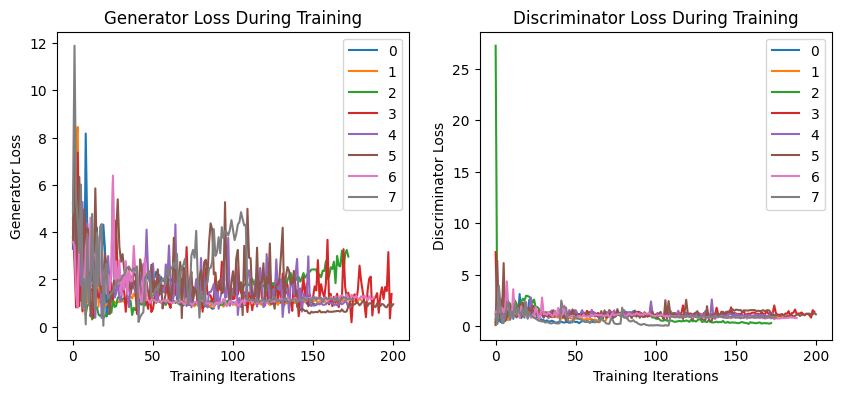

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for i, df in enumerate(result_dfs):
    axs[0].plot(df["lossg"], label=i)
axs[0].legend()
axs[0].set_title("Generator Loss During Training")
axs[0].set_xlabel("Training Iterations")
axs[0].set_ylabel("Generator Loss")

for i, df in enumerate(result_dfs):
    axs[1].plot(df["lossd"], label=i)
axs[1].legend()
axs[1].set_title("Discriminator Loss During Training")
axs[1].set_xlabel("Training Iterations")
axs[1].set_ylabel("Discriminator Loss")

plt.show()

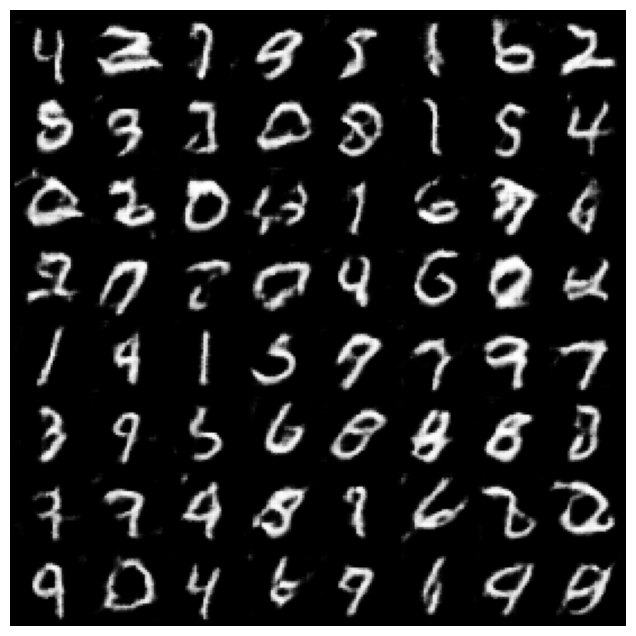

In [4]:
from ray.tune.examples.pbt_dcgan_mnist.common import demo_gan

with best_result.checkpoint.as_directory() as best_checkpoint:
    demo_gan([best_checkpoint])

Training of the MNist Generator should take a couple of minutes. The example can be easily altered to generate images for other datasets, e.g. cifar10 or LSUN.

## Summary


This tutorial covered:
1. **Two examples** of using Population Based Training to tune deep learning hyperparmeters (CNN and GAN training)
2. **Saving and loading checkpoints** and making sure that all hyperparameters are used (ex: optimizer state)
3. **Visualizing reported metrics** after training

To learn more, check out the next tutorial {doc}`/tune/examples/pbt_visualization/pbt_visualization` for a visual guide to understanding PBT and its underlying behavior.

If you have any questions, suggestions, or run into any problems please reach out on [Discuss](https://discuss.ray.io/), [GitHub](https://github.com/ray-project/ray) or the [Ray Slack](https://forms.gle/9TSdDYUgxYs8SA9e8)!
